# Lookiero Take Home Test

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 10000)
pd.set_option('display.width', 100000000)
import warnings

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.svm import SVC
import lightgbm as lgbm


In [2]:
# Read Data 
df = pd.read_csv('prueba.csv')

In [3]:
# Initial Preprocessing pipeline

# Dealing with missing values
df.isna().sum().sum()

0

- Feature extraction
- Nested cross validation 
- Feature selection with winning model 

In [4]:
# Feature Selection with Wrapper method 

from sklearn.preprocessing import StandardScaler

# Initialize  Standarization 
sc = StandardScaler()

#  Train / Test Split
from sklearn.model_selection import train_test_split

X, y = df.iloc[:, :-1].values, df.iloc[:, -1].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=1, 
                     stratify=y)

In [5]:
# Standarize Training  and Test data
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.fit_transform(X_test)

In [6]:
# Feature Extraction
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
X_train_sc = sc.fit_transform(X_train_sc)
X_train_pca = pca.fit_transform(X_train_sc)

X_test_sc = sc.fit_transform(X_test_sc)
X_test_pca = pca.fit_transform(X_test_sc)

In [11]:
# Set up 4 baselines

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Initialize baseline with fixed random_state
baseline_1 = RandomForestClassifier(random_state=1)
baseline_2 = lgbm.LGBMClassifier(random_state=1) 
baseline_3 = LogisticRegression(random_state=1)
baseline_4 = SVC(random_state=1)

# Fit Baseline with original training data
baseline_1.fit(X_train_pca, y_train)
baseline_2.fit(X_train_pca, y_train)
baseline_3.fit(X_train_pca, y_train)
baseline_4.fit(X_train_pca, y_train)


print(f'RF - Baseline Training Accuracy: {np.mean(baseline_1.predict(X_train_pca) == y_train)*100:.2f}% ')
print(f'RF - Baseline Test Accuracy: {np.mean(baseline_1.predict(X_test_pca) == y_test)*100:.2f}% ')

print(f'LGBM -Baseline Training Accuracy: {np.mean(baseline_2.predict(X_train_pca) == y_train)*100:.2f}% ')
print(f'LGBM - Baseline Test Accuracy: {np.mean(baseline_2.predict(X_test_pca) == y_test)*100:.2f}% ')

print(f'LR -Baseline Training Accuracy: {np.mean(baseline_3.predict(X_train_pca) == y_train)*100:.2f}% ')
print(f'LR - Baseline Test Accuracy: {np.mean(baseline_3.predict(X_test_pca) == y_test)*100:.2f}% ')

print(f'SVC -Baseline Training Accuracy: {np.mean(baseline_4.predict(X_train_pca) == y_train)*100:.2f}% ')
print(f'SVC - Baseline Test Accuracy: {np.mean(baseline_4.predict(X_test_pca) == y_test)*100:.2f}% ')

RF - Baseline Training Accuracy: 100.00% 
RF - Baseline Test Accuracy: 48.00% 
LGBM -Baseline Training Accuracy: 100.00% 
LGBM - Baseline Test Accuracy: 51.33% 
LR -Baseline Training Accuracy: 65.14% 
LR - Baseline Test Accuracy: 50.67% 
SVC -Baseline Training Accuracy: 97.14% 
SVC - Baseline Test Accuracy: 51.33% 


In [8]:

# Initialize parameters grid to perform Hiperparameter Optimization via GridSearchCV
parameter_grid1 = [{'n_estimators': [10, 100, 500, 1000, 10000]}]

parameter_grid2 = [ { 
                'learning_rate': [0.05],
                'n_estimators': [400,500,600,700,800,900,1000],
                'reg_alpha' : (1,1.2),
                'reg_lambda' : (1,1.2,1.4)
                }]
parameter_grid3 = [{'penalty': ['l2'],
                'C': np.power(10., np.arange(-4, 4))}]


parameter_grid4 = [{'kernel': ['rbf'],
                'C': np.power(10., np.arange(-4, 4)),
                'gamma': np.power(10., np.arange(-5, 0))},
               {'kernel': ['linear'],
                'C': np.power(10., np.arange(-4, 4))}]





In [15]:
# Setting up multiple GridSearchCV objects, 1 for each algorithm
gridcvs = {}
inner_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)

for pgrid, est, name in zip((parameter_grid1,
                             parameter_grid2, 
                             #parameter_grid3,
                             parameter_grid4),
                             
                            (baseline_1, baseline_2, baseline_4),

                            ('RF', 'LGBM', 'SVC')):
    gcv = GridSearchCV(estimator=est,
                       param_grid=pgrid,
                       scoring='accuracy',
                       n_jobs=1, 
                       cv=inner_cv,
                       verbose=0,
                       refit=True)
    gridcvs[name] = gcv

In [17]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)


for name, gs_est in sorted(gridcvs.items()):
    nested_score = cross_val_score(gs_est, 
                                   X=X_train_pca, 
                                   y=y_train, 
                                   cv=outer_cv,
                                   n_jobs=1) 
    print(f'{name:<7} | outer ACC {100*nested_score.mean():.2f}% +/- {100*nested_score.std():.2f}')

LGBM    | outer ACC 54.00% +/- 3.66
RF      | outer ACC 50.00% +/- 3.38
SVC     | outer ACC 47.71% +/- 6.10


In [18]:
# Based on Nested  nested cross validation we see that SCV performs the best
# Now we select the best hp on the whole trainin set

gcv_model_select = GridSearchCV(estimator=baseline_2,
                                param_grid=parameter_grid2,
                                scoring='accuracy',
                                n_jobs=1,
                                cv=inner_cv,
                                verbose=1,
                                refit=True)

gcv_model_select.fit(X_train_pca, y_train)
print('Best CV accuracy: %.2f%%' % (gcv_model_select.best_score_*100))
print('Best parameters:', gcv_model_select.best_params_)

Fitting 2 folds for each of 42 candidates, totalling 84 fits
Best CV accuracy: 52.57%
Best parameters: {'learning_rate': 0.05, 'n_estimators': 400, 'reg_alpha': 1.2, 'reg_lambda': 1}


In [20]:
from sklearn.metrics import accuracy_score
best_model = gcv_model_select.best_estimator_

train_acc = accuracy_score(y_true=y_train, y_pred=best_model.predict(X_train_pca))
test_acc = accuracy_score(y_true=y_test, y_pred=best_model.predict(X_test_pca))

print(f'Nested CV Accuracy {100 * gcv_model_select.best_score_:.2f}% (average over k-fold CV test folds)')
print(f'Best Parameters: {gcv_model_select.best_params_}')

print(f'Training Accuracy {100 * train_acc:.2f}%')
print(f'Test Accuracy {100 * test_acc:.2f}%')

Nested CV Accuracy 52.57% (average over k-fold CV test folds)
Best Parameters: {'learning_rate': 0.05, 'n_estimators': 400, 'reg_alpha': 1.2, 'reg_lambda': 1}
Training Accuracy 100.00%
Test Accuracy 56.67%


In [21]:
# Perform SFS on winning model

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
sfs1 = SFS(best_model, 
           k_features=(10, 30), # or (1, 13) and then select by hand 
           forward=True, 
           floating=False, 
           verbose=0,
           scoring='accuracy',
           cv=5)


sfs1 = sfs1.fit(X_train_pca, y_train)

best combination (ACC: 0.629): (6, 11, 15, 18, 19, 20, 23, 28, 31, 33, 35, 37)



(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Number of Features', ylabel='Performance'>)

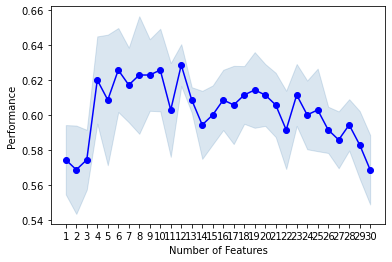

In [23]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
print('best combination (ACC: %.3f): %s\n' % (sfs1.k_score_, sfs1.k_feature_idx_))

plot_sfs(sfs1.get_metric_dict(), kind='std_err')

In [25]:
X_train_sfs = sfs1.transform(X_train_pca)
X_test_sfs = sfs1.transform(X_test_pca)

# Fit the estimator using the new feature subset
# and make a prediction on the test data
best_model.fit(X_train_sfs, y_train)

print(f' Best model Training Accuracy: {np.mean(best_model.predict(X_train_sfs) == y_train)*100:.2f}% ')
print(f'Best model Baseline Test Accuracy: {np.mean(best_model.predict(X_test_sfs) == y_test)*100:.2f}% ')

 Best model Training Accuracy: 100.00% 
Best model Baseline Test Accuracy: 52.00% 


In [ ]:
from sklearn.model_selection import validation_curve


param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0] #np.power(10., np.arange(-4, 4))
train_scores, test_scores = validation_curve(
                estimator=clf4, 
                X=X_train_select, 
                y=y_train, 
                param_name='C', 
                param_range = param_range,
                cv=5)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)



In [ ]:
plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='Validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
#plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
#plt.ylim([0.8, 1.0])
#plt.tight_layout()
# plt.savefig('figures/06_06.png', dpi=300)
plt.show()

In [23]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


train_sizes, train_scores, test_scores =\
                learning_curve(estimator=clf3,
                               X=X_train_select,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


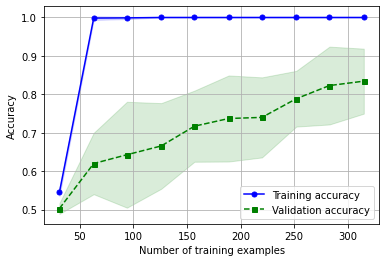

In [24]:
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
#plt.ylim([0.8, 1.03])
#plt.tight_layout()
# plt.savefig('figures/06_05.png', dpi=300)
plt.show()

The graph in the upper-right shows a model that suffers from high variance, which is indicated by the large gap between the training and cross-validation accuracy. To address this problem of overfitting, we can collect more training data, reduce the complexity of the model, or increase the regularization parameter, for example.
  [ 202 ]
 
Chapter 6
For unregularized models, it can also help to decrease the number of features via feature selection (Chapter 4, Building Good Training Datasets – Data Preprocessing)
or feature extraction (Chapter 5, Compressing Data via Dimensionality Reduction) to decrease the degree of overfitting. While collecting more training data usually tends to decrease the chance of overfitting, it may not always help, for example, if the training data is extremely noisy or the model is already very close to optimal.

In [ ]:
# Utilizaremos dos técnicas para mejorar el problema de overfitting. 
# Dado que el modelo ganador es un SVC. Vamos a incrementar el parametro de regularización
# Tambien vamos a reducir la complejidad del dataset aun más, quedando con solo los 5 atributos seleccionados por el método wrpaper SFS
# No vamos hacer Feature extraction con PCA por que hemos visto que la contrinución individual de los componentes es muy baja 


In [25]:
# Segunda iteración 


model_2it = lgbm.LGBMClassifier(random_state=1)  

model_2it.fit(X_train_sc, y_train)

print('Training accuracy:', np.mean(model_2it.predict(X_train_sc) == y_train)*100)
print('Test accuracy:', np.mean(model_2it.predict(X_test_sc) == y_test)*100)

Training accuracy: 100.0
Test accuracy: 50.0


In [26]:
sfs2 = SFS(model_2it, 
           k_features=5, # reducimos el dataset a 5 atributos
           forward=True, 
           floating=False, 
           verbose=0,
           scoring='accuracy',
           cv=5)


sfs2 = sfs2.fit(X_train_sc, y_train)

In [27]:
# Reducing Dataset based on SFS

X_train_select_2it = sfs2.transform(X_train_sc)
X_test_select_2it = sfs2.transform(X_test_sc)

In [ ]:
# Dado que el GridSearch que hicimos ya nos dio los mejores parametros no es necesario hacer uno de nuevo.
# Solo vamos a incrementar el parametro C y utilizar los que nos dio GScv :
# Best Parameters: {'learning_rate': 0.05, 'n_estimators': 400, 'reg_alpha': 1, 'reg_lambda': 1.4}

In [28]:
model_2it_best = lgbm.LGBMClassifier(random_state=1, learning_rate= 0.05,
n_estimators=400, reg_alpha=1, reg_lambda=1.4
)   # Solo incrementamos parametro C y nos quedamos con los best de GridScv

model_2it_best.fit(X_train_select_2it, y_train)
train_acc_2it = accuracy_score(y_true=y_train, y_pred=model_2it_best.predict(X_train_select_2it))
test_acc_2it = accuracy_score(y_true=y_test, y_pred=model_2it_best.predict(X_test_select_2it))


print(f'Training Accuracy {100 * train_acc_2it:.2f}%')
print(f'Test Accuracy {100 * test_acc_2it:.2f}%')

Training Accuracy 99.43%
Test Accuracy 47.33%


In [29]:
# learning curve

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=model_2it_best,
                               X=X_train_select_2it,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

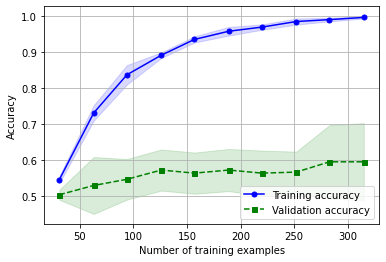

In [30]:
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
#plt.ylim([0.8, 1.03])
#plt.tight_layout()
# plt.savefig('figures/06_05.png', dpi=300)
plt.show()